## Micro Domain

The micro domain is defined by a bounding box and a smooth function parameterising the floor of the micro domain. 

In [2]:
import sys
sys.path.append('/home/emastr/phd/')

import numpy as np
import torch as pt
import torch.autograd as agrad
import matplotlib.pyplot as plt
from util.plot_tools import *
from architecture.fno_1d import *
from boundary_solvers.blobs import *
from boundary_solvers.geometry import *
from scipy.sparse.linalg import LinearOperator #, gmres
from operators.stokes_operator import StokesAdjointBoundaryOp
from boundary_solvers.geometry_torch import unpack_data, unpack, subsample, integrate, subdict, concat_dict_entries, to_dtype, mean_distance, projection
from boundary_solvers.geometry_torch import arclength, normalize, curvature, invariant_quantities, project_to_natural, to_device, GeomData, spectral_rescale
from torch.nn.utils import clip_grad_norm_
from util.unet import *
from util.logger import EventTracker
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import time

print("WARNING: sigmoid normalisation used for architectures older than 45")
print("WARNING: Error in dist_norm for architectures older than 48")


def get_net(settings, device, dtype):
    bias = settings["bias"] if "bias" in settings else True
    activation = settings["activation"] if "activation" in settings else F.gelu
    kernel_size = settings["kernel_size"] if "kernel_size" in settings else 1
    batch_norm = settings["batch_norm"] if "batch_norm" in settings else False
    
    net = FNO1d(modes=settings["modes"], 
                in_channels=len(settings["input_features"]), 
                out_channels=len(settings["output_features"]), 
                layer_widths=settings["layer_widths"],
                bias = bias,
                activation=activation,
                kernel_size=kernel_size,
                batch_norm=batch_norm,
                dtype=dtype)
    
    net.to(device)
    if settings["skip"]:
        class SkipNet(nn.Module):
            def __init__(self, net):
                super(SkipNet, self).__init__()
                self.net = net
            
            def forward(self, x):
                return self.net(x) + x[:, -4:, :]
        net = SkipNet(net)
    return net

### Setup

Load and transform the data, Split into training and test. Create network

In [3]:
# Meta
save_name = "fnoskip_big_data_49"
dtype = "float"
cdtype = torch.cfloat
device = "cpu"
data_dir = "/home/emastr/phd/data/micro_geometries_boundcurv_repar_256_torch/data_1.torch"

save = torch.load(f"/home/emastr/phd/data/runs/{save_name}_{40000}.Torch")
net = get_net(save["settings"], device, dtype)
net.load_state_dict(save["state dict"])

settings = save["settings"]
inp_features = save["settings"]["input_features"]
out_features = save["settings"]["output_features"]
key_features = ['vt', 'vn', 'dvt', 'dvn']  # These are the most important features.

# Data
data = GeomData(data_dir, inp_features, out_features, random_roll=True, device=device, dtype=torch.float)
M = len(data)
M_train = int(0.8*M)
M_batch = 32
n_half = 1 # Smallest size to rescale to during training


##### Execute code

train_data, test_data = random_split(data, [M_train, M-M_train])
train_loader = DataLoader(train_data, batch_size=M_batch, shuffle=True)
(X_test, Y_test)  = test_data[:]

# Predefine list of losses 
N = 40001 #50001 #30001
trainloss = []
testloss  = []

logger = EventTracker()

Do training

In [4]:
factors = np.linspace(0.1, 10, 40)
factors = (2 ** (np.arange(10, 24)/2)).astype(float)/256
losses = []
sizes = []
stds = []
for fac in factors:
    X_batch = spectral_rescale(X_test, fac)
    Y_batch = spectral_rescale(Y_test, fac)
    Y_net = net(X_batch)
    sizes.append(X_batch.shape[-1])
    losses.append(torch.mean((Y_batch - Y_net)**2).item()**0.5)
    stds.append(torch.std(torch.mean((Y_batch - Y_net)**2, axis=(-1, 1))**0.5).item())
    
losses = np.array(losses)
stds = np.array(stds)

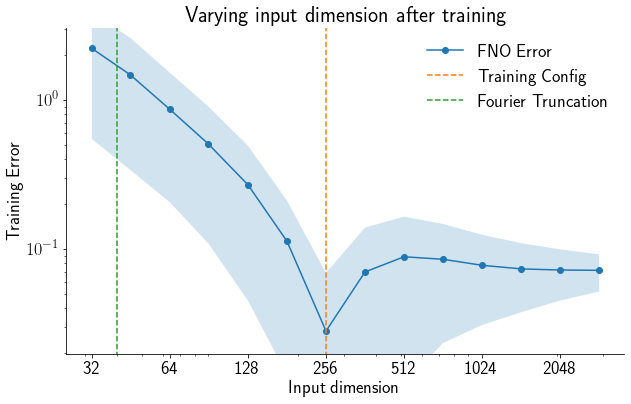

In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams['figure.figsize'] = [10, 6]
#matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['text.usetex'] = True

plt.plot(sizes, losses, 'o-', label="FNO Error")
plt.fill_between(sizes, losses-2*stds, losses+2*stds, alpha=0.2)
plt.plot([256, 256], [min(losses)-max(stds), max(losses)+max(stds)], '--', label="Training Config")
plt.plot([40, 40], [min(losses)-max(stds), max(losses)+max(stds)], '--', label='Fourier Truncation')
plt.legend(loc='upper right', frameon=False)
plt.title("Varying input dimension after training")
plt.xlabel("Input dimension")
plt.ylabel("Training Error")
plt.yscale("log")
plt.xscale("log")
xticks = 2 ** np.arange(5, 12)
plt.xticks(xticks, xticks)
plt.ylim([min(losses)-max(stds)/100, max(losses)+max(stds)])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.gcf().savefig(f"/home/emastr/phd/data/figures_math4dl/fno_error_vs_input_dim.pdf", bbox_inches='tight')

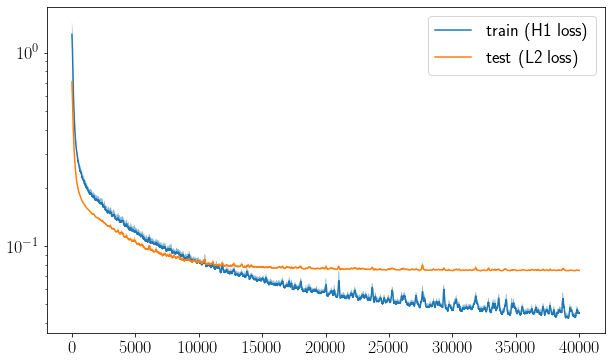

In [6]:
plt.figure()
trainloss = save["trainloss"]
testloss = save["testloss"]
settings = save["settings"]
window = 100
quantiles = np.array([0.8]) # 80% percentile upper bound
iters = np.arange(0,len(save["trainloss"]))
plot_quantiles(plt.gca(), iters, save["trainloss"], quantiles, window, label='train (H1 loss)')
plot_quantiles(plt.gca(), iters, save["testloss"], quantiles, window, label='test (L2 loss)')
plt.yscale("log")
#plt.xscale("log")
plt.legend()

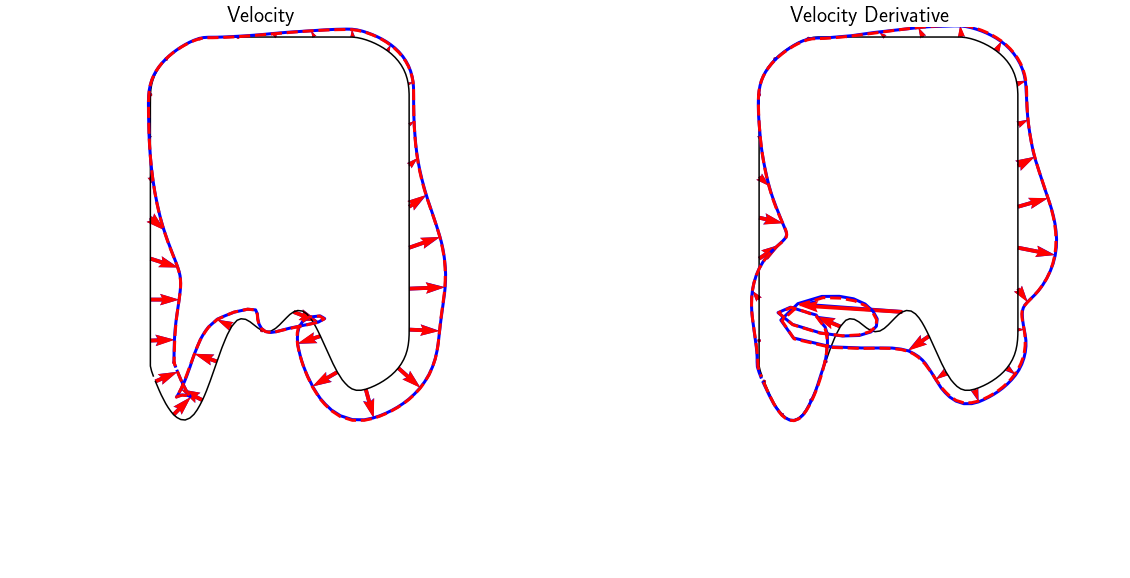

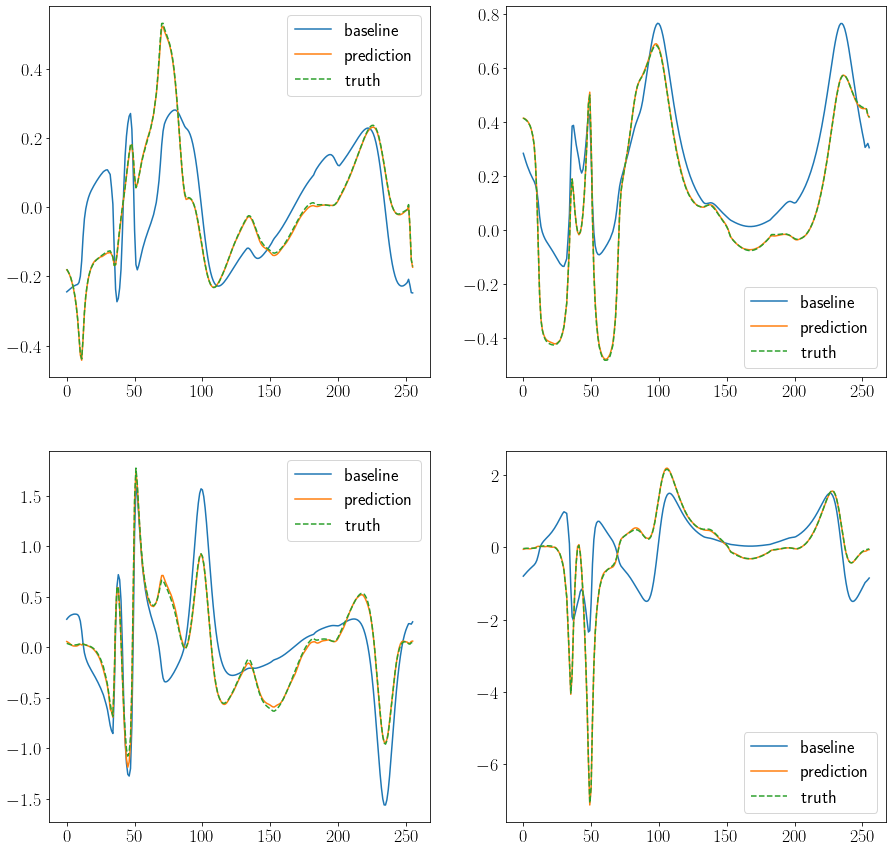

In [7]:
from boundary_solvers.geometry_torch import norm

idx = 124
test_data.dataset.random_roll = False
X_test, _ = test_data[idx:idx+1]
net.eval()
Y_net = net(X_test).squeeze().detach().cpu().numpy()
X_np_nat = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['tx', 'ty', 'vt', 'vn', 'dvt', 'dvn'])[0].squeeze().detach().cpu().numpy()
X_np = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['vx', 'vy', 'dvx', 'dvy'])[0].squeeze().detach().cpu().numpy()
Y_np = data.concat_to_tensor(test_data.indices[idx:idx+1], out_features=['rx', 'ry', 'drx', 'dry'])[1].squeeze().detach().cpu().numpy()
pts = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['x', 'y'])[0].squeeze().detach().cpu().numpy()


ux, uy = projection(Y_net[0], Y_net[1], X_np_nat[0], X_np_nat[1], inv=True)
Y_net[0], Y_net[1] = ux, uy

dv_norm = (np.linalg.norm(X_np_nat[-1])**2 + np.linalg.norm(X_np_nat[-2])**2)**0.5 / X_np_nat.shape[-1]**0.5
ux, uy = projection(Y_net[2]*dv_norm, Y_net[3]*dv_norm, X_np_nat[0], X_np_nat[1], inv=True)
Y_net[2], Y_net[3] = ux, uy

title = ["Velocity", "Velocity Derivative"]
plt.figure(figsize=(20,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.axis('off')
    plt.title(title[i])
    plt.plot(pts[0,:], pts[1,:], 'k')
    #plt.quiver(pts[0,:], pts[1,:], X_np[-4], X_np[-3], color='red',scale=s)
    
    s, scale, L = 8, (2*i+1)*4, 1.2
    mask = (pts[1] > -np.inf).astype(float)
    plt.quiver(pts[0,::s], pts[1,::s], mask[::s]*Y_net[2*i + 1, ::s]/scale, -mask[::s]*Y_net[2*i + 0, ::s]/scale, color='blue', scale_units='xy', scale=1)
    plt.quiver(pts[0,::s], pts[1,::s], mask[::s]*Y_np[2*i + 1, ::s]/scale, -mask[::s]*Y_np[2*i + 0, ::s]/scale, color='red', scale_units='xy', scale=1)
    
    plt.plot(pts[0]+mask*Y_net[2*i+1]/scale, pts[1]-mask*Y_net[2*i]/scale, linewidth=3, color='blue', label='prediction')
    plt.plot(pts[0]+mask*Y_np[2*i+1]/scale, pts[1]-mask*Y_np[2*i]/scale, '--', linewidth=3, color='red', label='true')
 
    
    plt.xlim([-L, L])
    plt.ylim([-L, L])

plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(X_np[i, :], label='baseline')
    plt.plot(Y_net[i, :], label='prediction')
    plt.plot(Y_np[i, :], '--', label='truth')
    plt.legend()
    

In [8]:
from boundary_solvers.geometry_torch import norm

idx = 124
test_data.dataset.random_roll = False
X_test, _ = test_data[idx:idx+1]
net.eval()
Y_net = net(X_test).squeeze().detach().cpu().numpy()
X_np_nat = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['tx', 'ty', 'vt', 'vn', 'dvt', 'dvn'])[0].squeeze().detach().cpu().numpy()
X_np = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['vx', 'vy', 'dvx', 'dvy'])[0].squeeze().detach().cpu().numpy()
Y_np = data.concat_to_tensor(test_data.indices[idx:idx+1], out_features=['rx', 'ry', 'drx', 'dry'])[1].squeeze().detach().cpu().numpy()
pts = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['x', 'y'])[0].squeeze().detach().cpu().numpy()


ux, uy = projection(Y_net[0], Y_net[1], X_np_nat[0], X_np_nat[1], inv=True)
Y_net[0], Y_net[1] = ux, uy

dv_norm = (np.linalg.norm(X_np_nat[-1])**2 + np.linalg.norm(X_np_nat[-2])**2)**0.5 / X_np_nat.shape[-1]**0.5
ux, uy = projection(Y_net[2]*dv_norm, Y_net[3]*dv_norm, X_np_nat[0], X_np_nat[1], inv=True)
Y_net[2], Y_net[3] = ux, uy


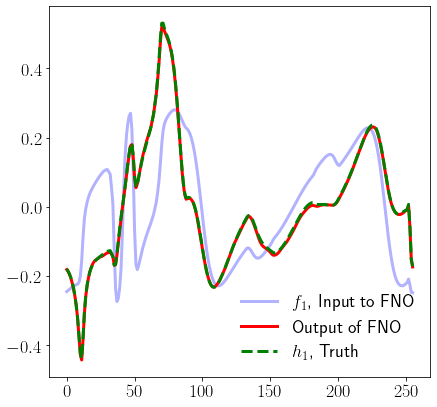

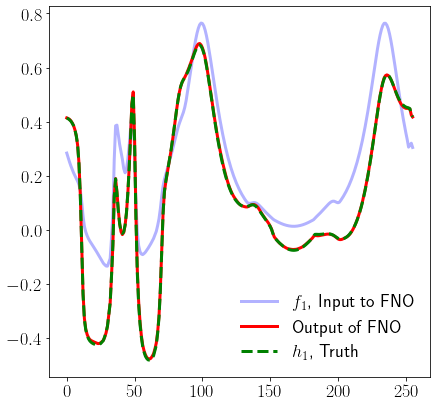

In [9]:
for i in range(2):
    plt.figure(figsize=(15,15))
    plt.subplot(2,2,i+1)
    plt.plot(X_np[i, :], 'blue', label='$f_1$, Input to FNO', linewidth=3, alpha=0.3)
    plt.plot(Y_net[i, :], 'red', label='Output of FNO', linewidth=3)
    plt.plot(Y_np[i, :], '--', color='green', label='$h_1$, Truth', linewidth=3)
    plt.legend(loc='lower right', frameon=False)
    plt.gcf().savefig('/home/emastr/phd/data/figures_math4dl/1d_vel_{}.pdf'.format(i), dpi=300, bbox_inches='tight')
    

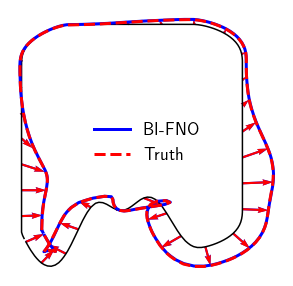

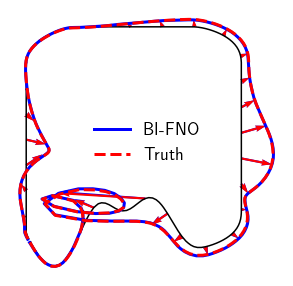

In [10]:
for i in range(2):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.plot(pts[0,:], pts[1,:], 'k')
    #plt.quiver(pts[0,:], pts[1,:], X_np[-4], X_np[-3], color='red',scale=s)
    
    s, scale, L = 8, (2*i+1)*4, 1.2
    mask = (pts[1] > -np.inf).astype(float)
    plt.quiver(pts[0,::s], pts[1,::s], Y_net[2*i + 1, ::s]/scale, -Y_net[2*i + 0, ::s]/scale, color='blue', scale_units='xy', scale=1)
    plt.quiver(pts[0,::s], pts[1,::s], Y_np[2*i + 1, ::s]/scale, -Y_np[2*i + 0, ::s]/scale, color='red', scale_units='xy', scale=1)
    
    plt.plot(pts[0]+mask*Y_net[2*i+1]/scale, pts[1]-mask*Y_net[2*i]/scale, linewidth=3, color='blue', label='BI-FNO')
    plt.plot(pts[0]+mask*Y_np[2*i+1]/scale, pts[1]-mask*Y_np[2*i]/scale, '--', linewidth=3, color='red', label='Truth')    
    plt.legend(loc='center', frameon=False)
    
    plt.gcf().savefig(f"/home/emastr/phd/data/figures_math4dl/field_plot_{i}.pdf", bbox_inches="tight", dpi=100)

1.1070615596493991


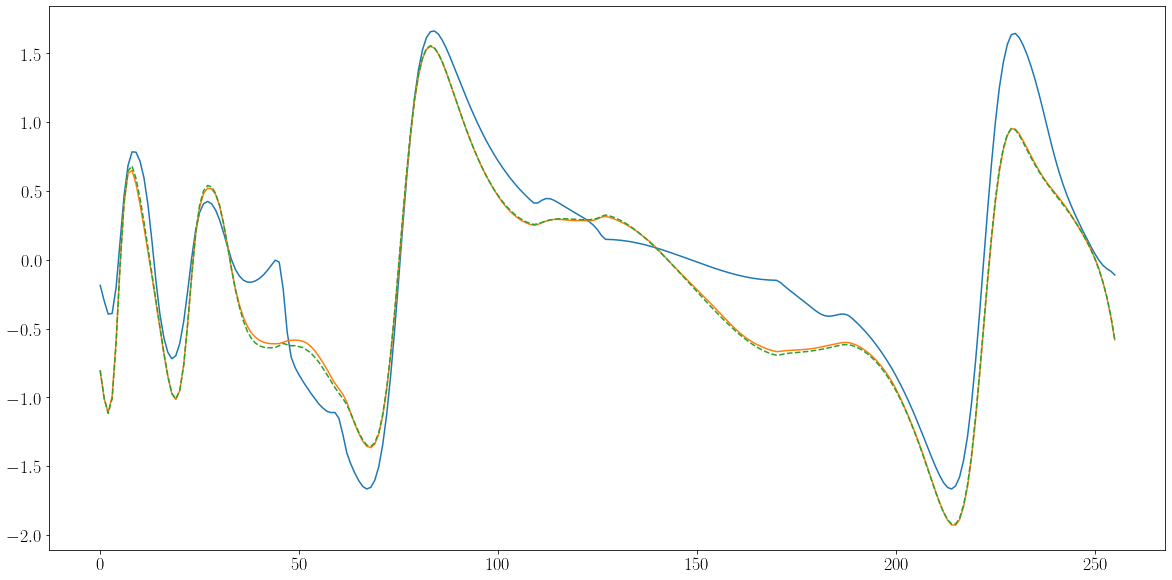

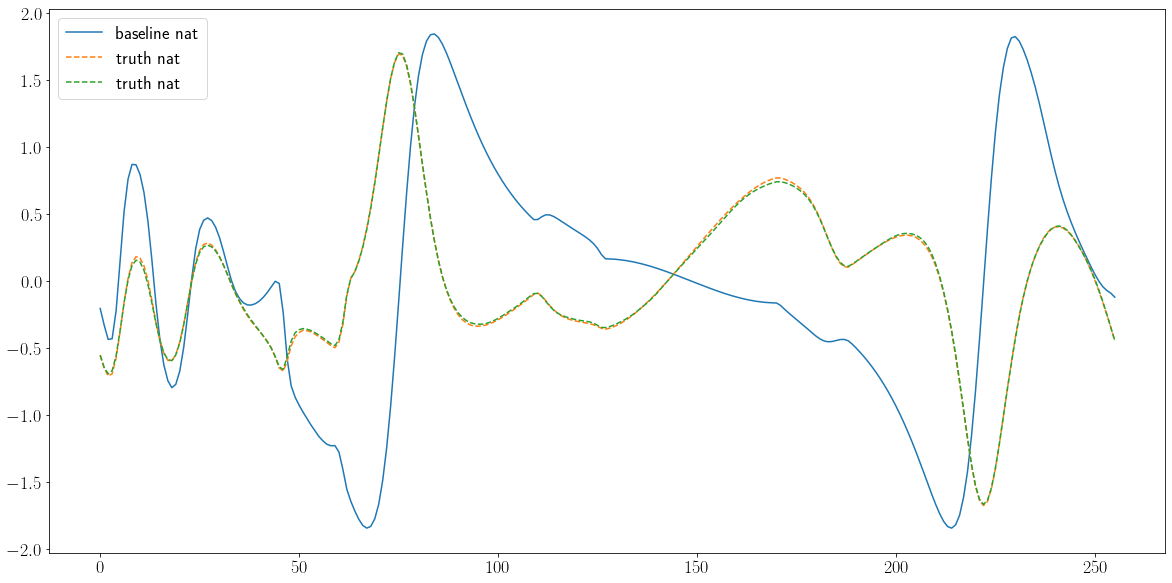

In [11]:
from boundary_solvers.geometry_torch import norm

idx = 5
test_data.dataset.random_roll = False
X_test, Y_test = test_data[idx:idx+1]
X_np = X_test[0, -2:].cpu().numpy()
Y_np = Y_test[0, -2:].cpu().numpy()
net.eval()
Y_net = net(X_test).squeeze().detach().cpu().numpy()[2:]

X_np_nat = data.concat_to_tensor(test_data.indices[idx:idx+1], inp_features=['tx', 'ty', 'dvt', 'dvn'])[0].squeeze().detach().cpu().numpy()
Y_np_nat = data.concat_to_tensor(test_data.indices[idx:idx+1], out_features=['drt', 'drn', 'drx', 'dry'])[1].squeeze().detach().cpu().numpy()



dv_norm = (np.linalg.norm(X_np_nat[-1])**2 + np.linalg.norm(X_np_nat[-2])**2)**0.5 / X_np_nat.shape[-1]**0.5
ux, uy = projection(Y_net[0]*dv_norm, Y_net[1]*dv_norm, X_np_nat[0], X_np_nat[1], inv=True)


print(dv_norm)

plt.figure(figsize=(20,10))
plt.plot(X_np[0, :], label='baseline')
plt.plot(Y_net[0, :], label='prediction')
plt.plot(Y_np[0, :], '--', label='truth')

plt.figure(figsize=(20,10))
plt.plot(X_np_nat[2, :], label='baseline nat')
plt.plot(Y_np_nat[2, :], '--', label='truth nat')
plt.plot(ux, '--', label='truth nat')
plt.legend()

    

In [12]:
from scipy.interpolate import interp1d
from boundary_solvers.geometry import GPDomain
default_parameters = {"kernel": "exp", "shape":.05, "num":20, "scale":.05, "bound":.3, "verbose": False, "width":1, "height":1, "corner_w":0.3, "line_pos":0.1, "n_refine":2, "n_corner_refine":0}
#randomisers = {"width": lambda: 0.5 + np.random.rand()*0.5, "scale": lambda: 0.01 + 10 ** (-np.random.rand()-1), "height": lambda: 0.5 + np.random.rand()*0.5, "corner_w": lambda: np.random.rand()*0.3 + 0.1, "line_pos": lambda: np.random.rand()*0.2 + 0.05}
randomisers = {"width": lambda: 0.5 + np.random.rand()*0.5, 
               "scale": lambda: 0.01 + 10 ** (-np.random.rand()-1), 
               "height": lambda: 0.7 + np.random.rand()*0.5, 
               "corner_w": lambda: np.random.rand()*0.2 + 0.1, 
               "line_pos": lambda: np.random.rand()*0.1 + 0.1}
to_randomise = ["height", "corner_w", "line_pos", "scale"]
#to_randomise = ["height", "line_pos", "corner_w"]
#to_randomise = ["line_pos"]
kwargs = {**default_parameters}
for key in to_randomise:
    kwargs[key] = randomisers[key]()
mg = GPDomain(**kwargs)


t = mg.grid.get_grid_and_weights()[0]
tu = np.linspace(0, np.pi*2, 256)


def stack_interp_eval(t, u, tev):
    tstack = np.concatenate([t-np.pi*2, t, t+np.pi*2])
    ustack = np.concatenate([u, u, u])
    return interp1d(tstack, ustack, kind='cubic')(tev)

z = mg.eval_param()
x, y = z.real, z.imag
r1, func = mg.precompute_line_avg(derivative=0, tol=1e-12, maxiter=200, verbose=False)
r3, _    = mg.line_eval_adjoint(derivative=0, tol=1e-12, maxiter=200, verbose=False)

r12, _ = mg.precompute_line_avg(derivative=0, tol=1e-1, maxiter=2, verbose=False)

r12 = stack_interp_eval(t, r12, tu)
r1 = stack_interp_eval(t, r1, tu)
r3 = stack_interp_eval(t, r3, tu)
x = stack_interp_eval(t, x, tu)
y = stack_interp_eval(t, y, tu)


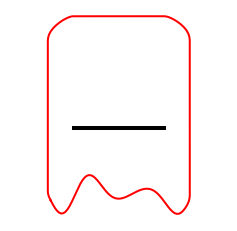

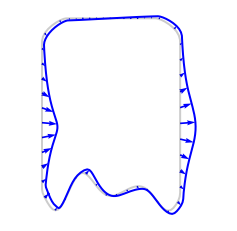

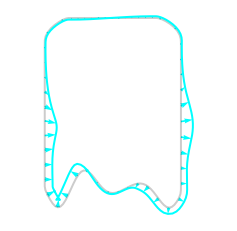

In [13]:

plt.figure(figsize = (4,4))
plt.axis('equal')
plt.axis('off')
mg.plot(ax=plt.gca(), showpts=False, show_samples=False, show_rounded=False, color='black', linewidth=2, alpha=0.)
plt.plot(x, y, color='red', linewidth=2)
plt.gcf().savefig('/home/emastr/phd/data/figures_math4dl/geometry.pdf', bbox_inches='tight', pad_inches=0)


plt.figure(figsize = (4,4))
plt.axis('equal')
plt.axis('off')
mg.plot(ax=plt.gca(), showpts=False, show_samples=False, show_hline=False, show_rounded=False, color='black', linewidth=2, alpha=0.2)
ss = 5
s = 8
plt.quiver(x[::ss], y[::ss], r3[::ss].imag/s, -r3[::ss].real/s, color='blue', scale_units='xy', scale=1)
plt.plot(x+r3.imag/s, y-r3.real/s, color='blue', linewidth=2)
plt.gcf().savefig('/home/emastr/phd/data/figures_math4dl/geometry_adjoint.pdf', bbox_inches='tight', pad_inches=0)

plt.figure(figsize = (4,4))
plt.axis('equal')
plt.axis('off')
mg.plot(ax=plt.gca(), showpts=False, show_samples=False, show_hline=False, show_rounded=False, color='black', linewidth=2, alpha=0.2)
ss = 5
s = 8
col = 'cyan' #[0.8, 0, 0.6]
plt.quiver(x[::ss], y[::ss], r1[::ss].imag/s, -r1[::ss].real/s, color=col, scale_units='xy', scale=1)
#plt.quiver(x[::ss], y[::ss], r12[::ss].imag/s, -r12[::ss].real/s, color='blue', scale_units='xy', scale=1)
plt.plot(x+r1.imag/s, y-r1.real/s, color=col, linewidth=2)
#plt.plot(x+r12.imag/s, y-r12.real/s, color='blue', linewidth=2)
plt.gcf().savefig('/home/emastr/phd/data/figures_math4dl/geometry_avg.pdf', bbox_inches='tight', pad_inches=0)